## Recommendation based on "Return Feature"
It is easy to understand that we recommend similar stocks to users, but how should we define similar stocks, similar stock could be explain from multiple perspectives, including fundamental aspects, technical aspects, today we will take technical aspects to make recommendation 
- 根据customer的历史购买记录进行推荐
- 你经常购买产品a，系统自动推荐和产品a属性类似的产品a1，a2等

cosin similarity：计算两个产品向量之间的角度，角度越小说明两个向量相似度越高

In [13]:
import pickle
import numpy as np
import pandas as pd
from IPython.display import display, Image
import tensorflow as tf

### Part 1: Read data

In [4]:
df = pd.read_csv("/Users/heyifan/jupyter notebook/df_featured.csv", index_col = "index")
df.head()

,Name,date,open,high,low,close,volume,return,vol_change
index,,,,,,,,,
2013-03,A,2013-03-01,41.18,41.9800,40.73,41.93,3089323,0.075125,-0.409335
2013-04,A,2013-04-01,41.83,41.9771,40.79,40.93,2541331,0.024432,0.215632
2013-05,A,2013-05-01,41.42,41.7400,41.26,41.31,2726213,-0.009199,-0.067816
2013-06,A,2013-06-03,45.65,45.8400,45.04,45.51,3677473,-0.092287,-0.258672
2013-07,A,2013-07-01,43.05,43.7700,42.91,43.59,4283821,0.044047,-0.141544


In [5]:
df.shape

(29507, 9)

### Part 2: Recommendation based on "Return Feature"
It is easy to understand that we recommended similar stocks to users, but how should we define similar stocks. 
- today we will take technical aspects to make recommendation

#### Part 2.1 extract one year stock return as target features

In [10]:
# 提取return作为feature 
# 留下每支股票最近12个月的数据；如果新上市的股票历史数据不足一年就不要了 
techFeatures = df[['Name', 'return']].groupby('Name').apply (lambda x: x.iloc[-12:,:] if x.shape[0] >= 12 else None)
techFeatures.head()

Name    return
Name index                 
A    2017-03    A -0.053420
     2017-04    A -0.021805
     2017-05    A -0.046595
     2017-06    A -0.081179
     2017-07    A  0.027059

In [11]:
techFeatures = techFeatures.reset_index(drop = True)
techFeatures.head()

,Name,return
0,A,-0.053420
1,A,-0.021805
2,A,-0.046595
3,A,-0.081179
4,A,0.027059


In [15]:
# 把每支股票最近12个月的return rate变成一个feature 
featureSeries = techFeatures.groupby('Name')['return'].apply(np.array)
featureSeries.head()

Name
A       [-0.05342044581091465, -0.021804511278195604, ...
AAL     [-0.06455723083457221, 0.10930506478209656, 0....
AAP     [0.024955322951238257, 0.07683848797250857, 0....
AAPL    [-0.07897560626654265, -0.027209464161447428, ...
ABBV    [-0.03087696960050923, -0.033830539750884236, ...
Name: return, dtype: object

In [16]:
stocks = featureSeries.index
stocks

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'XL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS'],
      dtype='object', name='Name', length=500)

In [19]:
featureSeries.values

array([array([-0.05342045, -0.02180451, -0.04659498, -0.08117899,  0.02705902,
       -0.01351351, -0.06896552, -0.00755357, -0.04630991, -0.00975397,
        0.01612426, -0.07181107]),
       array([-0.06455723,  0.10930506,  0.00879278, -0.1420999 , -0.02659258,
       -0.01312182,  0.12690355, -0.05070186, -0.00229933, -0.02367347,
       -0.07529723, -0.01651819]),
       array([ 0.02495532,  0.07683849,  0.03536611,  0.02501823,  0.1578414 ,
        0.03432914,  0.1674485 , -0.01308374,  0.2304644 , -0.18664384,
       -0.06419078, -0.09548981]),
       array([-0.07897561, -0.02720946, -0.01964797, -0.04308656,  0.06745645,
       -0.09515102, -0.03328254,  0.06657565, -0.07837498, -0.02432037,
       -0.00702427,  0.02670163]),
       array([-0.03087697, -0.03383054, -0.02181107, -0.00344776, -0.07884562,
        0.02014368, -0.05873774, -0.16561567, -0.02217655, -0.04028239,
       -0.02123768, -0.15411724]),
       array([-0.0392497 ,  0.05610901,  0.05867378, -0.114344  , -0.0

In [18]:
features = np.stack(featureSeries.values, axis = 0)
print(f"Stock feature dimension: {features.shape}")

Stock feature dimension: (500, 12)


In [20]:
features

array([[-0.05342045, -0.02180451, -0.04659498, ..., -0.00975397,
         0.01612426, -0.07181107],
       [-0.06455723,  0.10930506,  0.00879278, ..., -0.02367347,
        -0.07529723, -0.01651819],
       [ 0.02495532,  0.07683849,  0.03536611, ..., -0.18664384,
        -0.06419078, -0.09548981],
       ...,
       [-0.00319623, -0.02027194,  0.00438669, ...,  0.00453871,
        -0.07649524, -0.0322178 ],
       [-0.08747045,  0.11395739,  0.03084896, ..., -0.07707668,
        -0.0122288 , -0.07784649],
       [ 0.02653554,  0.01354147, -0.05525942, ..., -0.1077455 ,
         0.0073847 , -0.07774351]])

#### Part 2.2 Generate similarity matrix(cosine similarity)
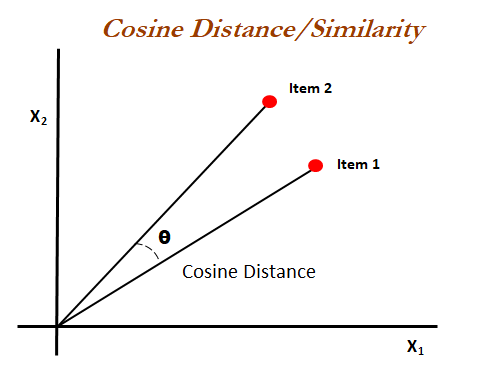

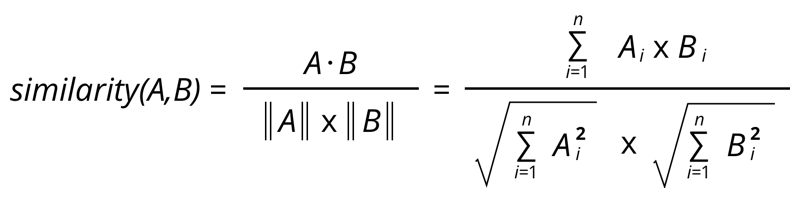

feature: 500支股票，每支股票有12个feature
similarity matrix：算每两支股票之间的相似度-结果是一个对称矩阵500 x 500

#### Matrix formula
A*B = m.T @ m  分母

norm = (m*m).sum(0, keepdims = True) ** .5  分子

||A|| = norm(m) 

||B|| = norm(m.T) 


In [27]:
### 使用tensor flow来计算一个产品的 similarity matrix
def cosine_similarity_matrix(featureMatrix):
    """
    calculate cosine similarity for user & item
    default: user is in row, item in column
    """
    M,N = featureMatrix.shape
    featuresTensor = tf.placeholder(tf.float32, shape = (M,N))
    
    #normalize each row
    normalized = tf.nn.l2_normalize(featuresTensor, dim = 1)
    
    prod = tf.matmul(normalized, normalized, adjoint_b = True)
    
    with tf.Session() as sess:
        ans = sess.run(prod,feed_dict={featuresTensor:featureMatrix})
    return ans

In [28]:
similarityMatrix = cosine_similarity_matrix(features)

In [30]:
similarityMatrix[:4, :4]

array([[ 0.99999994,  0.08999238, -0.26865953,  0.5282075 ],
       [ 0.08999238,  0.99999976,  0.30749297,  0.01634501],
       [-0.26865953,  0.30749297,  1.        , -0.26765984],
       [ 0.5282075 ,  0.01634501, -0.26765984,  0.99999994]],
      dtype=float32)

产品    1，2，3，4

1，

2，

3，

4

### Build recommend function
现在要推荐和a产品相似的产品
- 找到a产品所在的similarity matrix的呢一行
- 找到呢行中最大的数字对应的产品

In [36]:
def recommend_to_user(similarityMatrix, productID, top = 10):
    similarityRow = similarityMatrix[productID]
    
    similarityTennsor = tf.placeholder(tf.float32, shape=(len(similarityRow),))
    
    top_values, top_indices = tf.nn.top_k(similarityTennsor, k = top+1)
    
    with tf.Session() as sess:
        val,idx = sess.run([top_values,top_indices],feed_dict={similarityTennsor:similarityRow})
        
    return val[1:],idx[1:] ### avoid itself

In [37]:
# 0号这支股票，和他相似的10支股票分别是249，60，401 ... ...
recommend_to_user(similarityMatrix,0)

(array([0.9127154 , 0.8666705 , 0.86227864, 0.8579476 , 0.8543915 ,
        0.84936297, 0.8259804 , 0.81873626, 0.81311655, 0.81231976],
       dtype=float32),
 array([249,  60, 401, 115, 154, 268, 473, 204, 382, 234], dtype=int32))

### Part 3 Modulize

In [38]:
class recommendor:
    def __init__(self):
        pass
    def train(self,featureMatrix):
        self.similarityMatrix = self.cosine_similarity_matrix(featureMatrix)
    
    def cosine_similarity_matrix(self,featureMatrix):
        '''
        calculate cosine similarity for user & item

        default: user is in row, item in column
        ''' 
        M,N = featureMatrix.shape

        featuresTensor = tf.placeholder(tf.float32, shape = (M, N))

        # normalize each row
        normalized = tf.nn.l2_normalize(featuresTensor, dim = 1)

        prod = tf.matmul(normalized, normalized,adjoint_b = True) # transpose second matrix)

        with tf.Session() as sess:
            ans = sess.run(prod,feed_dict={featuresTensor:featureMatrix})

        return ans
    

    def recommend_to_user(self,productID,top=10,show_detail=True):
        ### function: If recommend 10 products based on productID provided, for eg: if user is holding Apple, function will recommend 10 stocks that are similar to apply
        similarityRow = self.similarityMatrix[productID]

        similarityTensor = tf.placeholder(tf.float32,shape=(len(similarityRow),))

        top_values, top_indices = tf.nn.top_k(similarityTensor, k=top+1)

        with tf.Session() as sess:
            val,idx = sess.run([top_values,top_indices],feed_dict={similarityTensor:similarityRow})

        if show_detail:
            print(f"For productID: {productID} ,similar {top} product are: {idx[1:]}, similarity values {val[1:]}")
        return val[1:],idx[1:] ### avoid itself

In [39]:
myRecommendor = recommendor()

In [40]:
myRecommendor.train(features)

In [41]:
myRecommendor.recommend_to_user(productID=10,top=5,show_detail=True)

For productID: 10 ,similar 5 product are: [ 32 333  96 116 123], similarity values [0.9016582  0.69438416 0.6479789  0.64523196 0.626183  ]


(array([0.9016582 , 0.69438416, 0.6479789 , 0.64523196, 0.626183  ],
       dtype=float32), array([ 32, 333,  96, 116, 123], dtype=int32))